In [1]:
lang = ['german', 'de'] # select your file's language
''' [['arabic', 'ar'], ['azerbaijani', 'az'], ['basque', 'eu'], ['bengali', 'bn'], ['catalan', 'ca'], ['chinese', 'zh'], 
['danish', 'da'], ['dutch', 'nl'], ['english', 'en'], ['finnish', 'fi'], ['french', 'fr'], ['german', 'de'], ['greek', 'el'], 
['hebrew', 'he'], ['hinglish', 'hi'], ['hungarian', 'hu'], ['indonesian', 'id'], ['italian', 'it'], ['kazakh', 'kk'], 
['nepali', 'ne'], ['norwegian', 'no'], ['portuguese', 'pt'], ['romanian', 'ro'], ['russian', 'ru'], ['slovene', 'sl'], 
['spanish', 'es'], ['swedish', 'sv'], ['tajik', 'tg'], ['turkish', 'tr']
'''
tags = [lang, 'sentence::mining', 'Tatort', 'sentence::recognition'] # input the desired tags for ANKI
fields = [lang, 'defs', tags] # decide on the number of fields and their contents for ANKI

In [2]:
# extract the tar zip
import tarfile

tar_path = r"C:\Users\paro\Documents\GitHub\SRT2CSV\es_core_news_sm-3.8.0.tar.gz"
extract_path = r"C:\Users\paro\Documents\GitHub\SRT2CSV\es_core_news_sm-3.8.0"

with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path=extract_path)


In [3]:
import spacy

# load from the correct folder
nlp = spacy.load(r"C:\Users\paro\Documents\GitHub\SRT2CSV\de_core_news_sm-3.0.0\de_core_news_sm-3.0.0\de_core_news_sm\de_core_news_sm-3.0.0")

# German sentence test
doc = nlp("Das Auto ist schnell.")

# iterate through tokens
for token in doc:
    print(token.text, token.pos_, token.dep_)


C:\Users\paro\Coding Projects\Cato-AI_vs1.2\cuda\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'de_core_news_sm' (3.0.0) was trained with spaCy v3.0.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Das DET nk
Auto NOUN sb
ist AUX ROOT
schnell ADV pd
. PUNCT punct


In [4]:
''' 
SRT2CSV
vsulli
26 April 2025
read in a .srt file 
convert to a df to perform nlp
export to a .csv file for upload to ANKI
'''

import csv
import json
import nltk
import numpy as np
import pandas as pd
import pysrt
import re
import seaborn as sns
import spacy
import string

from nltk.corpus import stopwords
lang_sw = stopwords.words(lang[0])
from textblob import TextBlob

from langdetect import detect, LangDetectException

# module that allows you to get meanings, translations, synonyms, and antonyms for supported langs
'''[bengali' (bn),'chinese (zh)', english' (en), 'french' (fr), 'german' (de), 
'italian' (it),'portuguese' (pt), 'romanian' (ro), 'russian'(ru), 'spanish'(es), 
'turkish' (tr)]'''
from PyMultiDictionary import MultiDictionary, DICT_EDUCALINGO
dictionary = MultiDictionary()

# allows for displaying multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
import tkinter as tk
from tkinter import filedialog

# keeps full GUI from appearing
root = tk.Tk()
root.withdraw()

# shows dialog box to ask for filename
filename = filedialog.askopenfilename()

''

In [6]:
# specify the encoding if UnicodeDecodeError
# you can open the file in NotePad and check SaveAs for default encoding
# ANSI, UTF-8
subs = pysrt.open(filename, encoding='utf-8')

In [7]:
def remove_formatting(subfile):
    # read through every sub line
    # using regex, delete section of line between <>
    # combine to string
    # update index
    for i in range(len(subfile)):
        # replace all characters between < and > with ""
        # using regex
        # strip white space from beginning
        subfile[i].text = subfile[i].text.lstrip()
        subfile[i].text = re.sub(r'<c.vtt_\w+>\s*"*', "", subfile[i].text)
        subfile[i].text = re.sub("</c>", "", subfile[i].text)
        # replace "-" with ""
        subfile[i].text = re.sub("-", "", subfile[i].text)

    return subfile

In [8]:
subs = remove_formatting(subs)

In [9]:
# create a dataframe with desired column name
def create_dataframe(subfile, col_name):
    # create dataframe
    df = pd.DataFrame(columns=[col_name])
    for i in range(len(subfile)):
        df.loc[i] = subfile[i].text
    return df

In [10]:
df = create_dataframe(subs, 'Subtitle')
df


,Subtitle
0,<font color=#ffffff>.</font>
1,<font color=#ffffff>(Motor wird angelassen)</f...
2,<font color=#ffffff>Herr Landsberger?</font>\n...
3,<font color=#ffffff>Motorhaube und Kofferraum ...
4,<font color=#ffffff>Machen Sie den Koffer auf!...
...,...
752,<font color=#ffffff>Haben Sie Verwandte in der...
753,<font color=#ffffff>Herr Landsberger?</font>\n...
754,<font color=#ffffff>Herr Trimmel'?</font>
755,<font color=#ffffff>Wohl ein Jugendbildnis von...


In [11]:
# TODO - fix to combine across rows
# combine rows until period or end character reached
# used for gaining more context for sentiment analysis and classification
# append these rows to list and then create new df - more efficient than appending to df
# end characters at index -1 must be ) . ? ! 

def combine_rows(df, col):
    new_df_list = []
    current_row = ""
    for row in df[col]:
        if row[-1] == ")" or row[-1] == "." or row[-1] == "?" or row[-1] == "!":
            current_row += row
            new_df_list.append(current_row)
            current_row = ""
        else:
            current_row += row

    # create new df from the list of combined rows
    new_df = pd.DataFrame(new_df_list)
    new_df.rename(columns={0:col}, inplace=True)
    return new_df
    

new_df = combine_rows(df, 'Subtitle')

In [12]:
# create new dataframe removing the subtitle font tags
# go row by row - only include what's between > and < symbols

def remove_font_tags(df, col):
    new_df_list = []
    current_row = ""
    for i in range(len(df[col])):
        # slice between two characters > and < 
        match = re.findall(r'>(.*?)<', df[col][i])
        if match:
            new_df_list.append(match[0])
        else:
            new_df_list.append(df[col][i])

    return new_df_list

In [13]:
new_df_list = remove_font_tags(df,'Subtitle')

# create new df without font tags
new_df = pd.DataFrame(new_df_list)
new_df.rename(columns={0:"Subtitle"}, inplace=True)
new_df


,Subtitle
0,.
1,(Motor wird angelassen)
2,Herr Landsberger?
3,"Motorhaube und Kofferraum öffnen,"
4,Machen Sie den Koffer auf!
...,...
752,Haben Sie Verwandte in der DDR?
753,Herr Landsberger?
754,Herr Trimmel'?
755,Wohl ein Jugendbildnis von Ihnen.


In [14]:
# basic exploratory data analysis
def explore_data(dataframe, column):
    print(dataframe.head())
    print(dataframe.shape)
    print(dataframe.dtypes)
    print(dataframe.describe(include='all'))
    
explore_data(new_df, 'Subtitle')

                            Subtitle
0                                  .
1            (Motor wird angelassen)
2                  Herr Landsberger?
3  Motorhaube und Kofferraum öffnen,
4         Machen Sie den Koffer auf!
(757, 1)
Subtitle    object
dtype: object
         Subtitle
count         757
unique        721
top     (Trimmel)
freq            6


In [15]:
# convert to lowercase
def make_lowercase(df, source_col, target_col):
    df[target_col] = df[source_col].str.lower()
    return df

In [16]:
# remove punctuation
def remove_punctuation(df, source_col, target_col):
    # ^ is a negation inside brackets (anything except)
    # starts with any word, digits, or underscore, white space character, apostrophe, + means any character in the string
    df[target_col] = df[source_col].str.replace(r"[^\w\s']+", ' ', regex = True)
    return df

In [17]:
# remove newline \n character
def remove_newline(df, source_col, target_col):
    df[target_col] = df[source_col].str.replace(r'\n', ' ', regex = True) # replaces the \n with a space
    return df

In [18]:
# remove newline from df
clean_df = remove_newline(new_df, 'Subtitle', 'Subtitle')
print(clean_df.head())

clean_df[102:103]

                            Subtitle
0                                  .
1            (Motor wird angelassen)
2                  Herr Landsberger?
3  Motorhaube und Kofferraum öffnen,
4         Machen Sie den Koffer auf!


,Subtitle
102,Jetzt reicht's.


In [19]:
# make lowercase
clean_df = make_lowercase(clean_df, 'Subtitle', 'Lowercase')
print(clean_df.head())


                            Subtitle                          Lowercase
0                                  .                                  .
1            (Motor wird angelassen)            (motor wird angelassen)
2                  Herr Landsberger?                  herr landsberger?
3  Motorhaube und Kofferraum öffnen,  motorhaube und kofferraum öffnen,
4         Machen Sie den Koffer auf!         machen sie den koffer auf!


In [20]:
# remove punctuation
clean_df = remove_punctuation(clean_df, 'Subtitle', 'No Punctuation')
print(clean_df.head())
clean_df[102:103]

                            Subtitle                          Lowercase  \
0                                  .                                  .   
1            (Motor wird angelassen)            (motor wird angelassen)   
2                  Herr Landsberger?                  herr landsberger?   
3  Motorhaube und Kofferraum öffnen,  motorhaube und kofferraum öffnen,   
4         Machen Sie den Koffer auf!         machen sie den koffer auf!   

                      No Punctuation  
0                                     
1             Motor wird angelassen   
2                  Herr Landsberger   
3  Motorhaube und Kofferraum öffnen   
4         Machen Sie den Koffer auf   


,Subtitle,Lowercase,No Punctuation
102,Jetzt reicht's.,jetzt reicht's.,Jetzt reicht's


In [25]:
# word tokenizer
# basic tokenizer splits on apostrophe
# tweet tokenizer does not

def tokenize_words(df, source_col):
    df['Word Tokens'] = df[source_col].apply(nltk.word_tokenize)
    return df

In [26]:
clean_df = tokenize_words(clean_df, 'No Punctuation')
clean_df['Word Tokens']

0                                          []
1                   [Motor, wird, angelassen]
2                         [Herr, Landsberger]
3       [Motorhaube, und, Kofferraum, öffnen]
4             [Machen, Sie, den, Koffer, auf]
                        ...                  
752     [Haben, Sie, Verwandte, in, der, DDR]
753                       [Herr, Landsberger]
754                        [Herr, Trimmel, ']
755    [Wohl, ein, Jugendbildnis, von, Ihnen]
756                                        []
Name: Word Tokens, Length: 757, dtype: object

In [27]:
def tokenize_sentences(df, source_col):
    df['Sentence Tokens'] = df[source_col].apply(nltk.sent_tokenize)
    return df

In [28]:

clean_df['Sentence Tokens'] = clean_df['No Punctuation'].apply(nltk.sent_tokenize)
clean_df['Sentence Tokens']

0                                      []
1                [ Motor wird angelassen]
2                      [Herr Landsberger]
3      [Motorhaube und Kofferraum öffnen]
4             [Machen Sie den Koffer auf]
                      ...                
752      [Haben Sie Verwandte in der DDR]
753                    [Herr Landsberger]
754                       [Herr Trimmel']
755    [Wohl ein Jugendbildnis von Ihnen]
756                                    []
Name: Sentence Tokens, Length: 757, dtype: object

In [29]:
# remove stopwords

# open existing file of removed words
def load_removed_words(lang):
    try:
        with open(lang[1]+"_removed_words.json", "r") as f:
            removed_words = set(json.load(f))
    #JSONDecodeError - if file is empty       
    except (FileNotFoundError, json.JSONDecodeError):
        removed_words = set()

    # add words 
    removed_words.update(lang_sw)

    # save new set
    with open(lang[1]+"_removed_words.json", "w") as f:
        json.dump(list(removed_words), f)
        
    # return set of removed words
    return removed_words

In [30]:
# extend the stop words with list of custom words

def extend_removed_words(lang, custom_stop_words):
    # save to JSON file
    try:
        with open(lang[1]+"_removed_words.json", "r") as f:
            removed_words = set(json.load(f))
    except FileNotFoundError:
        removed_words = set()

    removed_words.update(custom_stop_words)

    with open(lang[1]+"_removed_words.json", "w") as f:
        json.dump(list(removed_words), f)
        
    return removed_words

In [31]:
# remove from removed words file

def add_back_words(lang, desired_words):
    try:
        with open(lang[1]+"_removed_words.json", "r") as f:
            removed_words = set(json.load(f))

    except (FileNotFoundError, json.JSONDecodeError):
        removed_words = set()

    # add back words (remove from set)
    removed_words.difference_update(desired_words)

    with open(lang[1]+"_removed_words.json", "w") as f:
        json.dump(list(removed_words), f)
        
    return removed_words

In [39]:
removed_words = load_removed_words(lang)

# names of characters & places 
custom_stop_words = [
    "aber", "alle", "allem", "allen", "aller", "alles", "als", "also", "am", "an", "ander", "andere",
    "anderem", "anderen", "anderer", "anderes", "anderm", "andern", "anderr", "anders", "auch", "auf",
    "aus", "bei", "bin", "bis", "bist", "da", "damit", "dann", "das", "dass", "daß", "dasselbe", "dazu",
    "dein", "deine", "deinem", "deinen", "deiner", "deines", "dem", "demselben", "den", "denjenigen",
    "denen", "denn", "denselben", "der", "derer", "derselbe", "derselben", "des", "desjenigen", "dessen",
    "dich", "die", "diejenige", "diejenigen", "dieselbe", "dieselben", "diesem", "diesen", "dieser",
    "dieses", "dir", "doch", "dort", "du", "durch", "ein", "eine", "einem", "einen", "einer", "eines",
    "einig", "einige", "einigem", "einigen", "einiger", "einiges", "einmal", "er", "es", "etwas", "euch",
    "euer", "eure", "eurem", "euren", "eurer", "eures", "für", "gegen", "gewesen", "hab", "habe", "haben",
    "hat", "hatte", "hatten", "hier", "hin", "hinter", "ich", "ihm", "ihn", "ihnen", "ihr", "ihre", "ihrem",
    "ihren", "ihrer", "ihres", "im", "in", "indem", "ins", "ist", "jede", "jedem", "jeden", "jeder", "jedes",
    "jene", "jenem", "jenen", "jener", "jenes", "jetzt", "kann", "kein", "keine", "keinem", "keinen",
    "keiner", "keines", "könnte", "machen", "man", "manche", "manchem", "manchen", "mancher", "manches",
    "mein", "meine", "meinem", "meinen", "meiner", "meines", "mich", "mir", "mit", "muss", "musste",
    "nach", "nicht", "nichts", "noch", "nun", "nur", "ob", "oder", "ohne", "sehr", "sein", "seine",
    "seinem", "seinen", "seiner", "seines", "selbst", "sich", "sie", "sind", "so", "solche", "solchem",
    "solchen", "solcher", "solches", "soll", "sollte", "sondern", "sonst", "über", "um", "und", "uns",
    "unse", "unser", "unsere", "unserem", "unseren", "unserer", "unseres", "unter", "viel", "vom", "von",
    "vor", "war", "waren", "warst", "was", "weg", "weil", "weiter", "welche", "welchem", "welchen",
    "welcher", "welches", "wenn", "wer", "werde", "werden", "wie", "wieder", "will", "wir", "wird",
    "wirst", "wo", "wollen", "wollte", "würde", "würden", "zu", "zum", "zur", "zwar", "zwischen",
    
    "Aber", "Alle", "Allem", "Allen", "Aller", "Alles", "Als", "Also", "Am", "An", "Ander", "Andere",
    "Anderem", "Anderen", "Anderer", "Anderes", "Anderm", "Andern", "Anderr", "Anders", "Auch", "Auf",
    "Aus", "Bei", "Bin", "Bis", "Bist", "Da", "Damit", "Dann", "Das", "Dass", "Daß", "Dasselbe", "Dazu",
    "Dein", "Deine", "Deinem", "Deinen", "Deiner", "Deines", "Dem", "Demselben", "Den", "Denjenigen",
    "Denen", "Denn", "Denselben", "Der", "Derer", "Derselbe", "Derselben", "Des", "Desjenigen", "Dessen",
    "Dich", "Die", "Diejenige", "Diejenigen", "Dieselbe", "Dieselben", "Diesem", "Diesen", "Dieser",
    "Dieses", "Dir", "Doch", "Dort", "Du", "Durch", "Ein", "Eine", "Einem", "Einen", "Einer", "Eines",
    "Einig", "Einige", "Einigem", "Einigen", "Einiger", "Einiges", "Einmal", "Er", "Es", "Etwas", "Euch",
    "Euer", "Eure", "Eurem", "Euren", "Eurer", "Eures", "Für", "Gegen", "Gewesen", "Hab", "Habe", "Haben",
    "Hat", "Hatte", "Hatten", "Hier", "Hin", "Hinter", "Ich", "Ihm", "Ihn", "Ihnen", "Ihr", "Ihre", "Ihrem",
    "Ihren", "Ihrer", "Ihres", "Im", "In", "Indem", "Ins", "Ist", "Jede", "Jedem", "Jeden", "Jeder", "Jedes",
    "Jene", "Jenem", "Jenen", "Jener", "Jenes", "Jetzt", "Kann", "Kein", "Keine", "Keinem", "Keinen",
    "Keiner", "Keines", "Könnte", "Machen", "Man", "Manche", "Manchem", "Manchen", "Mancher", "Manches",
    "Mein", "Meine", "Meinem", "Meinen", "Meiner", "Meines", "Mich", "Mir", "Mit", "Muss", "Musste",
    "Nach", "Nicht", "Nichts", "Noch", "Nun", "Nur", "Ob", "Oder", "Ohne", "Sehr", "Sein", "Seine",
    "Seinem", "Seinen", "Seiner", "Seines", "Selbst", "Sich", "Sie", "Sind", "So", "Solche", "Solchem",
    "Solchen", "Solcher", "Solches", "Soll", "Sollte", "Sondern", "Sonst", "Über", "Um", "Und", "Uns",
    "Unse", "Unser", "Unsere", "Unserem", "Unseren", "Unserer", "Unseres", "Unter", "Viel", "Vom", "Von",
    "Vor", "War", "Waren", "Warst", "Was", "Weg", "Weil", "Weiter", "Welche", "Welchem", "Welchen",
    "Welcher", "Welches", "Wenn", "Wer", "Werde", "Werden", "Wie", "Wieder", "Will", "Wir", "Wird",
    "Wirst", "Wo", "Wollen", "Wollte", "Würde", "Würden", "Zu", "Zum", "Zur", "Zwar", "Zwischen"
]


removed_words = extend_removed_words(lang, custom_stop_words)

desired_words = []
removed_words = add_back_words(lang, desired_words)

In [40]:
# create new column without all removed words
clean_df['No Stop Words'] = clean_df['Word Tokens'].apply(lambda x: [item for item in x if item not in removed_words])
clean_df[100:120]

,Subtitle,Lowercase,No Punctuation,Word Tokens,Sentence Tokens,No Stop Words
100,In Leipzig gekauft.,in leipzig gekauft.,In Leipzig gekauft,"[In, Leipzig, gekauft]",[In Leipzig gekauft],[gekauft]
101,Musst du immer kurze Röcke tragen?,musst du immer kurze röcke tragen?,Musst du immer kurze Röcke tragen,"[Musst, du, immer, kurze, Röcke, tragen]",[Musst du immer kurze Röcke tragen],"[Musst, immer, kurze, Röcke, tragen]"
102,Jetzt reicht's.,jetzt reicht's.,Jetzt reicht's,"[Jetzt, reicht, 's]",[Jetzt reicht's],"[reicht, 's]"
103,Hast du vor mir noch nie,hast du vor mir noch nie,Hast du vor mir noch nie,"[Hast, du, vor, mir, noch, nie]",[Hast du vor mir noch nie],"[Hast, nie]"
104,Für wen mache ich das alles?,für wen mache ich das alles?,Für wen mache ich das alles,"[Für, wen, mache, ich, das, alles]",[Für wen mache ich das alles],"[wen, mache]"
105,Für Erich,für erich,Für Erich,"[Für, Erich]",[Für Erich],[Erich]
106,"Für uns beide, dachte ich.","für uns beide, dachte ich.",Für uns beide dachte ich,"[Für, uns, beide, dachte, ich]",[Für uns beide dachte ich],"[beide, dachte]"
107,Da kannst du alleine,da kannst du alleine,Da kannst du alleine,"[Da, kannst, du, alleine]",[Da kannst du alleine],"[kannst, alleine]"
108,Ich lass mir wegen dem,ich lass mir wegen dem,Ich lass mir wegen dem,"[Ich, lass, mir, wegen, dem]",[Ich lass mir wegen dem],"[lass, wegen]"
109,(Tür knallt),(tür knallt),Tür knallt,"[Tür, knallt]",[ Tür knallt],"[Tür, knallt]"


In [34]:
clean_df[100:101]['Subtitle']
clean_df[0:20]['No Stop Words']

100    In Leipzig gekauft.
Name: Subtitle, dtype: object

0                                      []
1                     [Motor, angelassen]
2                                  [Herr]
3        [Motorhaube, Kofferraum, öffnen]
4                   [Machen, Sie, Koffer]
5                  [Die, Sitzbank, bitte]
6                    [Das, Kind, schläft]
7              [Und, außerdem, geht, gut]
8                         [Handschuhfach]
9                                 [Danke]
10                               [hörbar]
11                                [Hörst]
12    [Ärmliche, Nee, förmliche, Anfrage]
13              [Strafverfolgungsbehörde]
14                       [Auf, Rastplatz]
15                          [fand, toten]
16                  [Keine, Verletzungen]
17                      [Hier, lies, mal]
18              [trug, Kind, DDRKleidung]
19                            [Was, geht]
Name: No Stop Words, dtype: object

In [36]:
# create a frequency diagram without stop words

# list of all words
words = []
for index, row in clean_df.iterrows():
    for word in row['No Stop Words']:
        words.append(word)
words[0:20]

['Motor',
 'angelassen',
 'Herr',
 'Motorhaube',
 'Kofferraum',
 'öffnen',
 'Machen',
 'Sie',
 'Koffer',
 'Die',
 'Sitzbank',
 'bitte',
 'Das',
 'Kind',
 'schläft',
 'Und',
 'außerdem',
 'geht',
 'gut',
 'Handschuhfach']

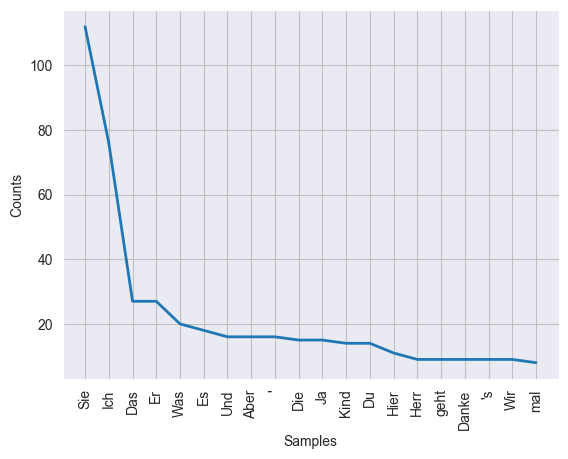

<Axes: xlabel='Samples', ylabel='Counts'>

In [37]:
# plot the word frequency
sns.set_style('darkgrid')
freq_words = nltk.FreqDist(words)
freq_words.plot(20)

In [38]:
# PyMultiDictionary to get definition

# retrieves part of speech, explanations
print(dictionary.meaning('de', 'hund', dictionary=DICT_EDUCALINGO))


(['Noun'], 'small to medium-sized mammal, who is kept as a pet especially because of his watchfulness and affection, has a well-trained sense of hearing and smell and can bite and bark male dog human, male common man, lump, rogue small box-shaped tram. small to medium-sized mammal that is kept as a pet, has a well-trained sense of hearing and smell, and bites and barks, especially for its watchfulness and affection © Eric Isselée - Fotolia.com © Eric Isselée - Fotolia.comExamplesA sharp, dangerous, stray, the dog barks, whines, yaps, beats the dog dog does not bite a dog holding a dog, lead on a lead, leash training dogs, breed dogs to be attacked, the dogs go wild. kleines bis mittelgroßes Säugetier, das besonders wegen seiner Wachsamkeit und Anhänglichkeit als Haustier gehalten wird, einen gut ausgebildeten Gehör- und Geruchssinn besitzt und beißen und bellen kann männlicher Hund Mensch, Mann gemeiner Mann, Lump, Schurke kleiner kastenförmiger Förderwagen. kleines bis mittelgroßes Sä

In [88]:
# extract only desired language from definition
def extract_desired_lang(word, lang):
    # Get the dictionary result
    res = dictionary.meaning(lang, word, dictionary=DICT_EDUCALINGO)
    
    if not res or not res[1]:
        return None
    
    pos_tags, text, _ = res
    
    # split into sentences
    sentences = text.split('. ')
    
    # desired language sentences
    my_sentences = []
    
    for sent in sentences:
        sent = sent.strip() 
        if not sent:
            continue
        
        try:
            detected_lang = detect(sent)
            
            # check if desired lang
            if detected_lang == lang:
                my_sentences.append(sent)
        except LangDetectException:
            # skip if not desired lang
            continue
    
    # combine sentences and return
    return ' '.join(my_sentences)

In [96]:
no_stop = ['Tisch', 'Flügel']

    
def get_article_for_noun(noun):
    # Process the noun using spaCy
    doc = nlp(noun)

    # Check if it's a noun and has a valid gender tag
    # only works if appropriately capitalized
    for token in doc:
        if token.pos_ == "NOUN":
            # Based on the gender, return the correct article
            if token.morph.get("Gender") == ["Masc"]:
                return "der"
            elif token.morph.get("Gender") == ["Fem"]:
                return "die"
            elif token.morph.get("Gender") == ["Neut"]:
                return "das"
            else:
                return ""
    return None


In [98]:
# export sentences to a .csv file

# construct a dictionary entry for all words in desired column
# word [pos]: definition
# space
# word2 [pos]: definition
def construct_csv(df, source_col, fields):
    dict_entry = ""
    article = ""
    for w in no_stop:
        if get_article_for_noun(w):
            article = get_article_for_noun(w)
        else:
            article = ""

        dict_entry += article + " " + w + " [" + dictionary.meaning(lang[1], w, dictionary=DICT_EDUCALINGO)[0][0] + "] : " +  extract_desired_lang(w, lang[1]) + "\n\n"

    print(dict_entry)
    
    # word from no stop words col ; definition ; tags

In [ ]:
# TODO

# update get article for noun, add language parameter and add spanish


# change opening of stopword file to create file if that language file does not already exist

# add a flag to include title case of all words to stop words as well
# ich is a stop word, Ich is not


# add export of all sentences to a .csv file
# field separator ;
    # DEU     # dict def of no-stop-words column    # tags
    
# change export to .csv to only include desired number of no stop words/unknown words (1, 2, 3) etc.

# refactor code & formatting

# create new requirements txt

# add function to find and load correct spacy model

# fix function that combines across rows

# change educalingo dictionary to web scraping an actual dictionary for better definitions and articles for nouns?
# add article & plural of noun - create new function that finds it based on language (key = lang & gender, value = der, die, das or el, la, etc.)
    
#  Parts of speech tagging - NLP

# Notepad++ convert ANSI to UTF-8 for special characters
# seems to need to be UTF-8 BOM in order to preserve special characters

# hinglish doesn't have an official language code